# Project 2: Neural networks and PyTorch

This practical will run over three weeks and is divided in three sections:

Project 2.1: Linear and logistic regression in PyTorch (week 5)

Project 2.2: Neural networks (week 6)

Project 2.3: Application of neural networks to a case study (week 7)

Only for Project 2.3 there are deliverables that will be graded. However, Project 2.3 builds on the theoretical concepts and libraries introduced in Projects 2.1 and 2.2. You can already start working on Project 2.3 during week 5 and week 6 but only after you have completed all the exercises of the corresponding week.

NB: If you want to work on this notebook with your group simultaneously, i.e. more people working from different laptops on the same jupyter notebook, you can try out Google Colab by clicking this button: Make sure you also download on the Google Drive where the notebook is located, the corresponding function (.py files!)

<a target="_blank" href="https://colab.research.google.com/github/Computational-Biology-TUe/8BB020_Intro-machine-learning/blob/main/practicals/part_1_neural_networks.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Project 2.1: Linear and logistic regression in PyTorch
## Linear and logistic regression as computational graphs

We begin by showing how linear and logistic regression can be seen as (very small) computational graphs. We will show later how these small graphs serve as the basic building blocks that can be stacked together to form more complex models (spoiler alert: the more complex models are neural networks!).

The computational graph for a linear regression model with two input variables ($x_1$ and $x_2$) is shown below.

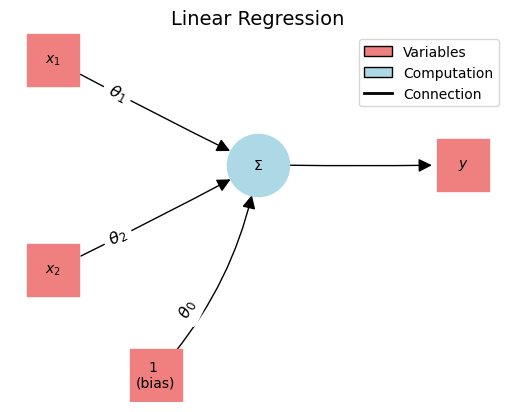

In [119]:
import figures

figures.plot_linear_regression()

$
\begin{align}
y = \theta_0 \cdot 1 + \theta_1 x_1 + \theta_2 x_2
\end{align}
$

The main difference between the linear and logistic models is the addition of the sigmoid function. This function squashes the weighted sum of the input variables to a range between $[0, 1]$, allowing the output to be interpreted as the probability $p(y=1)$. Linear regression, on the other hand, directly outputs a continuous value between $[-\infty, \infty]$. The computational graph for the logistic regression model is shown below.

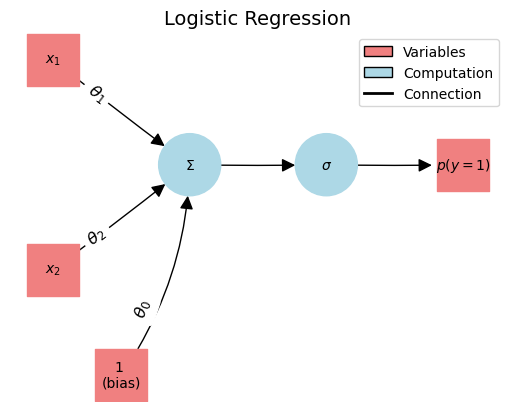

In [120]:
import figures

figures.plot_logistic_regression()

$
\begin{align}
p(y=1) = \sigma(\theta_0 \cdot 1 + \theta_1 x_1 + \theta_2 x_2)
\end{align}
$

where,

$
\begin{align}
\sigma(a) = \frac{1}{1 + e^{-a}}
\end{align}
$

### Some observations

- There are two types of nodes in these graphs:
    1) <b style="color:#ff6961;">**Variables**</b> (data), shown as red squares: These include input features and output values.
    2) <b style="color:#aec6cf;">**Computation**</b>, shown as blue circles: These include operations such as summation ($\Sigma$) and activation functions like the sigmoid function ($\sigma$).
- The arrows indicate connections between the nodes and are (usually) associated with weight parameters (e.g., $\Theta_1$). The weight parameters scale the value of the variables before passing them to the next node.
- The bias node is also shown as "data,", it represents a node that typically has a constant value of one with an associated weight.
- The data flows in one direction: from left (input) to right (output), i.e. there are no loops in the graph.
- The form and function of these models loosely resemble those of biological neurons (see figure below), thus they can be considered **"artificial neurons"**.

Indeed, logistic regression can be considered as the smallest building block of neural networks, as we will see later.

In [121]:
from IPython.display import Image, Markdown, display

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Blausen_0657_MultipolarNeuron.png/640px-Blausen_0657_MultipolarNeuron.png'
source_url = 'https://commons.wikimedia.org/wiki/File:Blausen_0657_MultipolarNeuron.png'
display(Image(url=url))
display(Markdown(f"**Image Source:** [Wikipedia]({source_url})"))

**Image Source:** [Wikipedia](https://commons.wikimedia.org/wiki/File:Blausen_0657_MultipolarNeuron.png)

<div class="alert alert-block alert-warning">
<b>Important:</b> The sections below are not intended to be a complete PyTorch tutorial. Rather, the goal of the examples and exercises is to make a bridge with programming and theory components introduced in part 1 and introduce new components. Many PyTorch tutorials exist on the internet and we recommend <a href="https://pytorch.org/tutorials/beginner/basics/intro.html">this one</a> from their website, which covers the basics of the library. It is highly recommended and probably essential to go over it before proceeding. 
</div>

## PyTorch

PyTorch is a highly popular machine learning framework known for its flexibility and ease of use. It can be used in a variety of different ways (and not just for machine learning) but two particularly interesting features to note are:
- Support for automatic differentiation (autograd): This means that PyTorch can automatically compute gradients for the machine learning models. This feature simplifies the process of optimizing machine learning models implemented in PyTorch. It is particularly important for highly complex models such as deep neural networks as we do not have to write down the complex formulas for the gradients (PyTorch will do that for us!).
- Support for GPU Acceleration: This means that PyTorch can leverage GPUs to perform computations much faster than on a CPU. This capability is very important for training large-scale models and handling vast amounts of data. This is even mode important for high-dimensional data such as images. But if you do not have a suitable GPU do not worry - all exercises here can be done perfectly fine on the CPU.

Here is how the MyLinearRegression function, which you implemented in part 1 of the practicals, would look like if we implement it using pure PyTorch:

In [122]:
import torch
import torch.optim as optim

class MyPyTorchLinearRegression:
    def __init__(self, epochs=1000, learning_rate=0.01):
        self.theta = None
        self.bias = None
        self.epochs = epochs
        self.learning_rate = learning_rate

    def fit(self, X, y):
        self.theta, self.bias = self._solve_gradient_descent(X, y, self.epochs, self.learning_rate)

    def _solve_gradient_descent(self, X, y, epochs, learning_rate):
        n_samples, n_features = X.shape        
        self.theta = torch.randn(n_features, requires_grad=True)        
        self.bias = torch.randn(1, requires_grad=True)

        # use the built-in gradient descent optimizer
        optimizer = optim.SGD([self.theta, self.bias], lr=learning_rate)
        
        for _ in range(epochs):            
            # clear the previously computed gradients
            optimizer.zero_grad()             
            
            predictions = X.matmul(self.theta) + self.bias
            error = predictions - y
            loss = (error ** 2).mean()
                                    
            # compute the gradients for the loss with respect to the parameters
            # this is the autograd part!
            loss.backward()  
            
            # update the parameters using the computed gradients
            optimizer.step()             

        return self.theta, self.bias

    def predict(self, X):
        # convert X to a PyTorch tensor if it is not already
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)

        # gradient calculation not needed for inference
        with torch.no_grad():  
            return X.matmul(self.theta) + self.bias


In essence, instead of `numpy` arrays we are using `PyToch` tensors and instead of `numpy` functions we are using `PyTorch` functions. Tensors are multidimensional arrays, just like `numpy` arrays, but with additional capabilities such as the ability to run on GPUs for accelerated computations. In addition, PyTorch tensors support automatic differentiation (autograd), which is essential for building and training neural networks. 

We can test the code with the same dataset as in the linear regression exercises from part 1. The computed MSE over the training set should be very similar.

MSE: 78.05424499511719


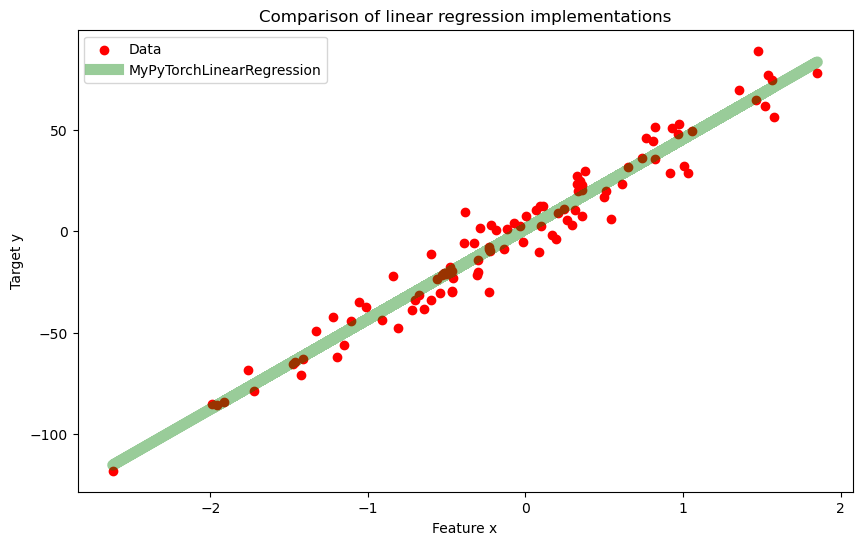

In [123]:
from tests import generate_regression_data, plot_regression

# use the same data as in the exercises in part I
X_, y_ = generate_regression_data()

# convert numpy arrays to PyTorch tensors
X = torch.from_numpy(X_).float()
y = torch.from_numpy(y_).float().view(-1)

model = MyPyTorchLinearRegression()
model.fit(X, y)

predictions = model.predict(X)

error = predictions - y
mse = (error ** 2).mean()

print(f'MSE: {mse}')
plot_regression(X_, y_, [predictions.detach().numpy()], ['MyPyTorchLinearRegression'])

Note that we do not need to explicitly compute the gradient of the loss with respect to the parameters, as this is automatically handled by PyTorch when we call `loss.backward()`. This method triggers the backward pass, which computes the gradients of the loss function relative to the model’s parameters by using automatic differentiation. This process makes our job easier, as we only need to focus on implementing the forward pass: the computation that produces predictions. For example, in linear regression, the forward computation is `predictions = X.matmul(self.theta) + self.bias`, where we calculate the predicted values based on the model parameters.

While implementing the forward computation is very simple for linear regression, this way of using PyTorch is not very handy when we need to implement more complex models such as neural networks. (In fact, models are almost never implemented in this manner in practice, we just showed this example to make an analogy with part 1 of the practical exercises).

The `torch.nn` module provides a high-level interface for building and training neural networks with pre-defined layers, loss functions, and utilities that will make our job-task easier when implementing larger models. 

In PyTorch, implementing machine learning models often involves a layered approach where you build complex networks by stacking together simpler, modular layers provided by the `torch.nn` library. A layer in the context of neural networks is a fundamental computational unit that transforms input data into output data through a set of mathematical operations. This method leverages object-oriented programming by defining each layer as an instance of a class, allowing you to encapsulate functionality and maintain clean, readable code. By initializing these layers in the `__init__` method and defining how data flows through them in the forward method, you can create flexible and reusable components. This  simplifies the process of building larger models and makes it easier to debug and extend them for various applications.

Here is how the linear regression example would look like:

In [124]:
import torch
import torch.nn as nn

class LinearRegressionModel(nn.Module):
    # here we define the "building blocks"
    # in this case we only have a linear layer block
    # with two input features and one output
    def __init__(self, input_dim=2):
        super(LinearRegressionModel, self).__init__()
        self.output = nn.Linear(input_dim, 1)

    # and here we define how the data flows throught the building blocks
    # in this case the input data is simply passed trought the single linear layer
    def forward(self, x):
        p = self.output(x)
        return p


The training is usually implemented outside of the model class. Here we again use the built-in gradient descent optimizer:

MSE: 78.05424499511719


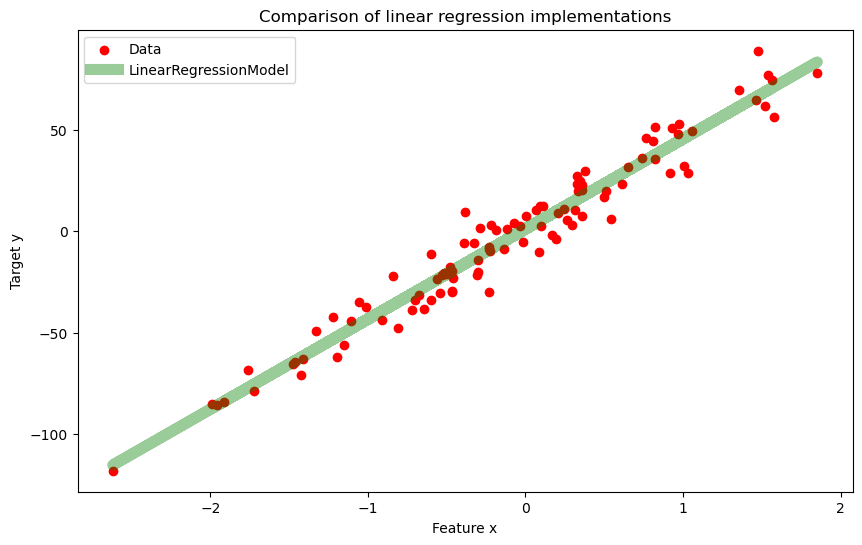

In [125]:
import torch.optim as optim
from tests import generate_regression_data, plot_regression

X_, y_ = generate_regression_data()

#Convert numpy array to tensor, make it float,
X = torch.from_numpy(X_).float()

y = torch.from_numpy(y_).float().view(-1,1) #additional column reshape to column vector (n x 1)

input_dim = X.shape[1]

num_epochs = 1000
learning_rate = 0.01

model = LinearRegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for _ in range(num_epochs):
    model.train()

    predictions = model(X)    
    
    loss = criterion(predictions, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# set the model to evaluation mode
model.eval()

# compute the MSE on the training set
with torch.no_grad():
    train_predictions = model(X)
    train_mse = criterion(train_predictions, y)
    
print(f'MSE: {train_mse.item()}')
plot_regression(X.detach().numpy(), y.detach().numpy(), [train_predictions.detach().numpy()], ['LinearRegressionModel'])

## Exercise 1: Implementation of logistic regression in PyTorch 

In this exercise, your goal is to extend the linear regression implementation using ```torch.nn``` to a logistic regression model. Hint: you have to add a sigmoid layer and incoorporate it in the forward computation of the model.

In [126]:
class LogisticRegressionModel(nn.Module):
    #chat GPT
    def __init__(self, input_dim=2):
        super(LogisticRegressionModel, self).__init__()
        # Linear layer: computes z = XW^T + b
        self.linear = nn.Linear(input_dim, 1)
        # Sigmoid layer: squashes z into range [0, 1]
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        # Step 1: linear transformation
        z = self.linear(x)
        # Step 2: apply sigmoid activation
        p = self.sigmoid(z)
        return p


    # START EXERCISE 2.1 #
    #'''

    #'''
    # END EXERCISE 2.1

To test your implementation, we can again use the same dataset as the exercises in Part I:

In [127]:
from tests import generate_classification_data

X_, y_ = generate_classification_data()

# convert numpy arrays to PyTorch tensors
X = torch.from_numpy(X_).float()
y = torch.from_numpy(y_).float().view(-1, 1)

You can train this model in a similar way as linear regression. The loss should, of course, be different and suitable for a classification task. So, we are using a binary cross entropy loss (a.k.a. negative log-likelihood).

In [128]:
input_dim = X.shape[1]
num_epochs = 1000
learning_rate = 0.1

model = LogisticRegressionModel(input_dim)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()

    predictions = model(X)  
    
    # compute the loss
    loss = criterion(predictions, y)
    
    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

model.eval()

with torch.no_grad():
    train_predictions = model(X)
    train_loss = criterion(train_predictions, y)
    print(f'Binary Cross Entropy Loss: {train_loss.item()}')

Binary Cross Entropy Loss: 0.28024905920028687


Let's also plot the decision boundary in a similar style as in Part I:

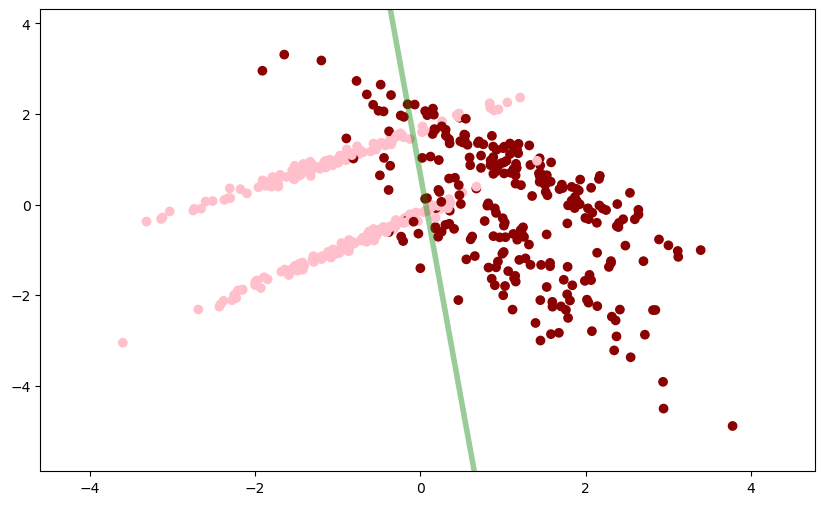

In [129]:
from tests import create_mesh_grid
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 

x1_mesh, x2_mesh, x_mesh = create_mesh_grid(X_)
y_pred_mesh = model(torch.from_numpy(x_mesh).float()).reshape(x1_mesh.shape)
y_pred_mesh = y_pred_mesh.detach().numpy()

plt.figure(figsize=(10, 6))
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap=ListedColormap(['pink', 'darkred']), label='Data')
plt.contour(
        x1_mesh, x2_mesh, y_pred_mesh, levels=[0.5], colors='green', 
        linewidths=4, alpha=0.4, linestyles='-'
    );  

<font color="red">

1. The linear layer has trainable parameters, which are the weights associated witht the output features. Does the sigmoid layer have any trainable parameters?
    
2. What makes the negative log-likelihood (also known as binary cross-entropy, `nn.BCELoss`) more suitable for this neural network compared to the mean squared error loss? Can you train this network using MSE loss? In which case would MSE be a suitable loss function for a neural network?

3. What would be the effect of having a very low value for the learning rate? How about a very high learning rate?

</font>



1. Trainable paremeters are ... 

2.

3. 



# Project 2.2: Neural networks 

## The AND and XOR classification toy problems: when linear is not enough

Let's now look at two "toy" classification problems that will help us illustrate when simple linear decision boundaries are not suitable for obtaining good classification performance. They are called the AND and XOR datasets, since they resemble the [AND](https://en.wikipedia.org/wiki/Logical_conjunction) and the [XOR](https://en.wikipedia.org/wiki/Exclusive_or) operations on binary variables:

| A AND B | 0   | 1   |
|-------|-----|-----|
| **1**     | 0   | 1   |
| **0**     | 0   | 0   |

| A XOR B | 0   | 1   |
|-------|-----|-----|
| **1**     | 1   | 0   |
| **0**     | 0   | 1   |


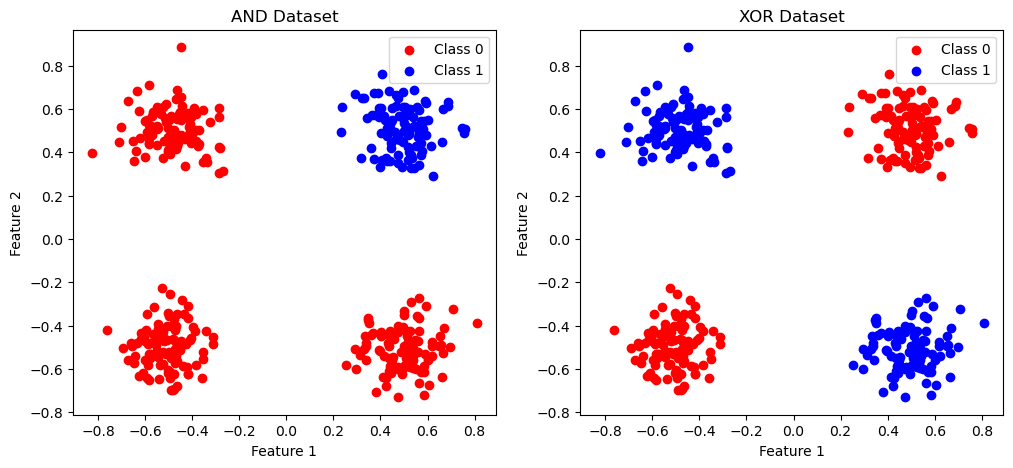

In [130]:
from demos import ANDXORToyDatasets

demo_datasets = ANDXORToyDatasets()
demo_datasets.plot()

We can observe that for the AND toy dataset, a linear classification boundary, such as one produced by a logistic regression model, will be able to split the 2D features space such that blue class (top right cluster) will be correctly separated from the red class (the remaining three clusters). This is a **linearly separable** classification problem.

However, in the XOR toy dataset that has a more complex structure, any linear decision boundary will always misclassify at least one of the clusters. You can try that yourself by drawing boundaries on a piece of paper. In other words, the XOR dataset is **not linearly separable**.

You can also verify this by passing a PyTorch model to the `run()` method of the class. This is a convenience functionality that we provide for these exercises. In the background, it will train the model with a binary cross-entropy loss and stochastic gradient descent and plot the results for the two datasets.

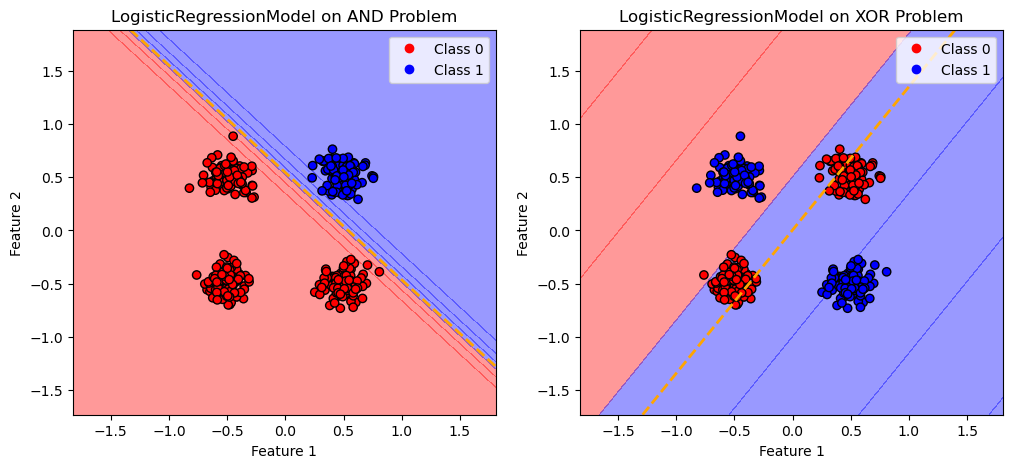

In [131]:
demo_datasets.run(LogisticRegressionModel());

For the XOR dataset, a more complex model is required. A common approach to adding complexity to the model is to generate additional input features by transforming the original  features. Specifically, for this example, analyzing the plot provides a "hint" that a quadratic transformation can produce an effective decision boundary.

The hint comes from observing the placement of the data points in the plot: the points in each class are positioned in such a way that no single straight line can separate them. However, by including quadratic terms such as $x_1^2$, $x_2^2$, and the interaction term $x_1 \cdot x_2$, the model can capture the necessary non-linear relationships. These quadratic features allow the decision boundary to "bend and curve", effectively separating the classes of the XOR dataset. The computational graph for this model is illustrated below.


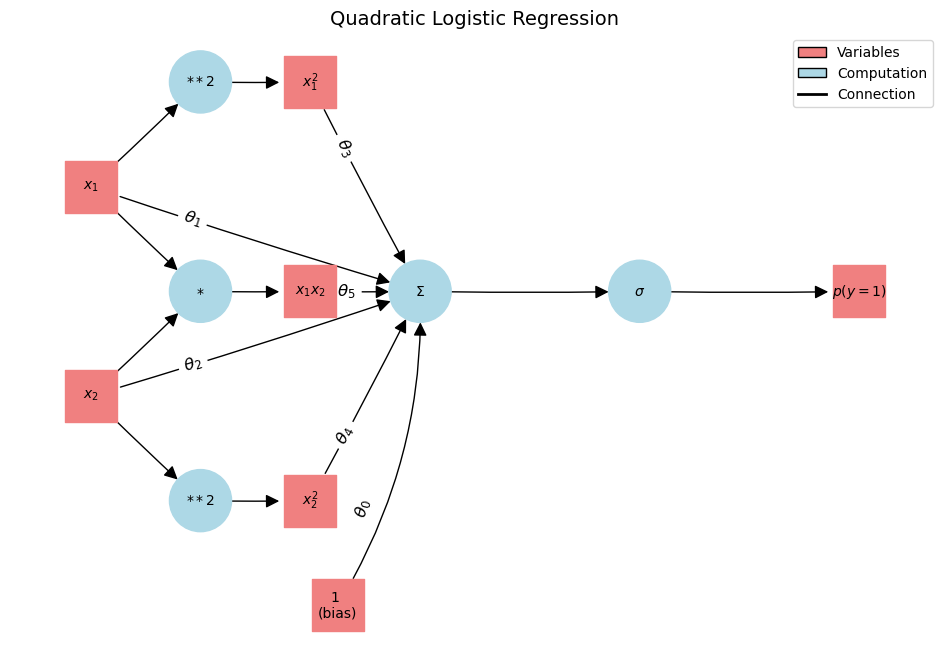

In [132]:
import figures

figures.plot_quadratic_logistic_regression()

Note that this model can be seen as a "logistic regression with 5 input features", 2 of which are the original ones and 3 are the quadratic transformations. The model is still **linear in the parameters** ($\Theta$) but non-linear (quadratic) in the input features ($x_i$). This is also reflected in the implementation below. We still have only the linear and sigmoid layers, so essentially this uses the same building blocks as logistic regression. However, the flow of the data through the building blocks is modified in the sense that we first compute the quadratic transformation of the input features and then we pass those to the layers. Here is how the Pytorch model and the solution would look like:

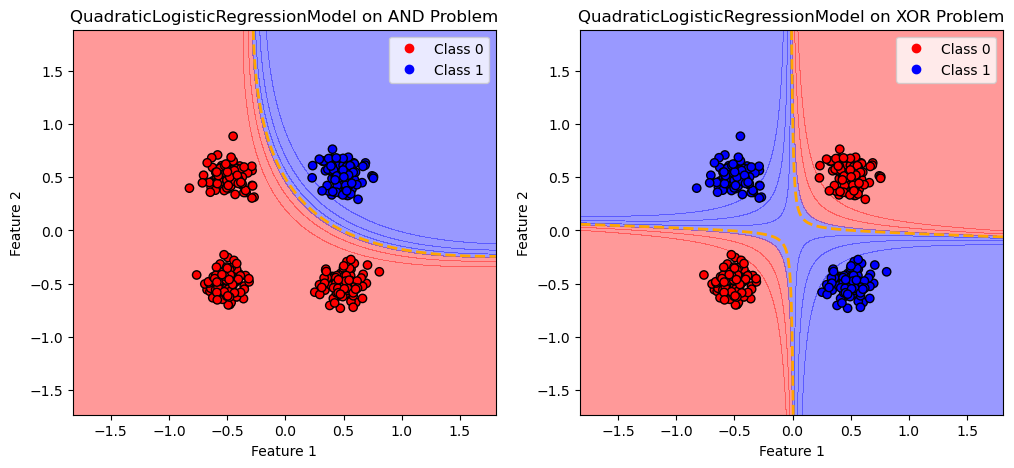

In [133]:
class QuadraticLogisticRegressionModel(nn.Module):
    def __init__(self):
        super(QuadraticLogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(5, 1)
        self.output = nn.Sigmoid()

    def forward(self, x):
        if x.shape[1] != 2:
            raise ValueError("Input must have exactly 2 features.")
            
        x1 = x[:, 0]
        x2 = x[:, 1]
        x1_squared = x1 ** 2
        x2_squared = x2 ** 2        
        x1x2 = x1 * x2
        x_transformed = torch.stack([x1, x2, x1_squared, x2_squared, x1x2], dim=1)

        p = self.output(self.linear(x_transformed))
        
        return p
        

demo_datasets.run(QuadraticLogisticRegressionModel());

## You just did feature engineering

We can see that the quadratic logistic regression model can effectively solve the XOR classification problem. By introducing new (in this case, quadratic) feature transformations, we performed **feature engineering**. Feature engineering refers to the process of using domain knowledge to create new features or modify existing ones to improve the performance of a machine learning model.

Feature engineering can be a critical step in building effective machine learning models. It involves transforming raw data into a format that better captures the underlying patterns needed for prediction. In the context of the XOR problem, the quadratic features $x_1^2$, $x_2^2$, and $x_1 \cdot x_2$ allow the model to learn a non-linear decision boundary, which a simple linear model cannot achieve.

The type of transformations used depends on the specific classification problem and prior knowledge about the characteristics of the different classes, often referred to as **domain knowledge**. For example, if we are designing a classifier to diagnose a specific type of brain tumor in CT images, we can rely on insights from radiology studies that describe the typical appearance of such tumors. Using this information, we can design image filters to highlight those characteristics and then summarize the outputs of those filters (e.g. by taking the average over the scan) and use it as input features for our models. Similarly, if we are classifying tumors based on molecular features such as gene expression, and we know that a specific tumor type arises from the interaction of particular genes, we can include the product of the gene expression for those genes as new features. This targeted transformation helps the model capture relevant interactions and improves its performance.

Feature engineering is a time-consuming and often incomplete process. Domain knowledge can be limited or incomplete, leading to missed opportunities for creating potentially valuable features. Not all useful transformations may be obvious or known. Some interactions and non-linear relationships in the data might be too complex to capture with simple feature engineering techniques. Capturing domain knowledge with handcrafted feature transformations also requires a lot of input from domain experts, e.g. radiologists for CT images, and their time can be scarce and expensive. But as we will shortly see, there is an alternative approach.

## It takes two to XOR

If you look at the XOR classification problem again, you might observe that it can be successfully solved using two linear classification boundaries. For example, one linear boundary (such as the one obtained from a logistic regression model) can separate the top right red cluster from the remaining three. A second decision boundary can separate the bottom left cluster. Then, we only need to merge these two classification results to obtain the complete solution. Here is how a computational graph that achives this by combining the outputs of two logistic regression models looks like. 

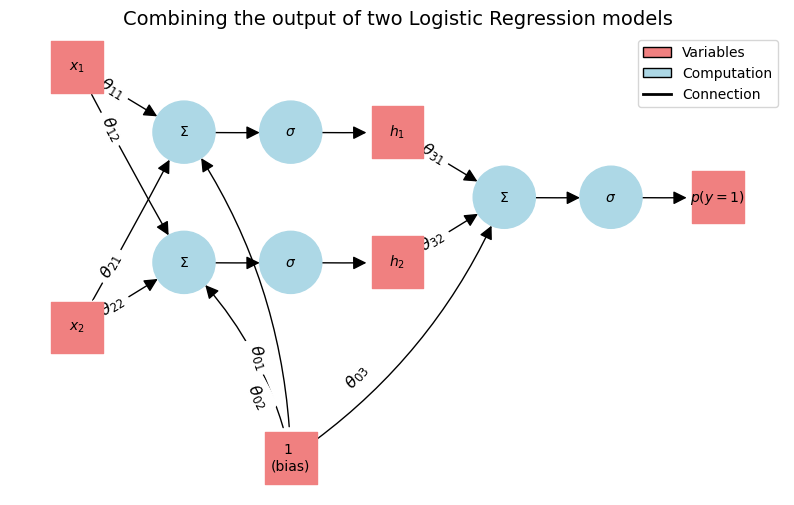

In [134]:
import figures

figures.takes_two_to_xor()

We have replicated the computational graph for logistic regression twice. Both models take the two input features, $x_1$ and $x_2$, and produce output variables named $h_1$ and $h_2$. These outputs, $h_1$ and $h_2$, represent the two separate linear decision boundaries. These are then combined using a third logistic regression model, effectively merging the results to produce the final output.

## A very small neural network

By looking at the computational graph above, you might have already guessed that we have just created a neural network (even if it was a very small one). Indeed, the model that combines two linear decision boundaries can be seen as a **feed-forward neural networks**. Let's break down these terms:

- **Feed-forward** refers to the unidirectional flow of information from input to output, without any feedback loops, which contrasts with architectures like recurrent neural networks (not covered in this course).
- **Neural** indicates that the form and function of these networks are loosely inspired by biological neurons, where each node performs a simple computation and passes the result to the next layer.
- **Network** implies that these simple units (neurons) are interconnected, forming a complex structure capable of learning from data.

In this example, the neural network consists of three aritificial neurons, each corresponding to one of the "logistic regression classifiers" in the computational graph. If fact, it is common to merge the linear node ($\Sigma$), sigmoid nonlinearity node ($\sigma$) and output node ($h$)into one when depicting neural networks. Additionally, the bias is not depicted:



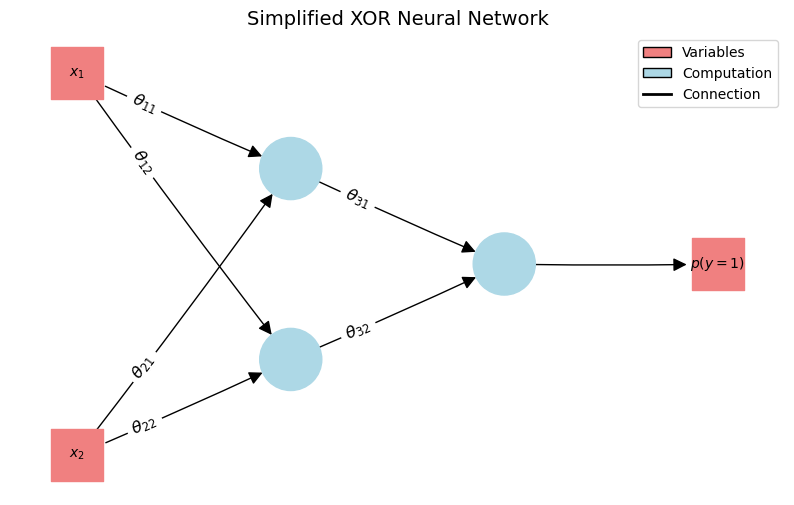

In [135]:
import figures

figures.small_nn(include_bias=False)

Again, an analogy can be made with how biological nurons are organized into more complex stuctures where the axons of one **layer** of neurons are connected to the dendrites of the next layer, like in the figure below illustrating part of the human cortex.

In [136]:
from IPython.display import Image, Markdown, display

url = 'https://www.oreilly.com/api/v2/epubs/9781492037354/files/assets/mlst_1002.png'
source_url = 'https://www.oreilly.com/library/view/neural-networks-and/9781492037354/ch01.html'
display(Image(url=url))
display(Markdown(f"**Image Source:** [O'Railly]({source_url})"))


**Image Source:** [O'Railly](https://www.oreilly.com/library/view/neural-networks-and/9781492037354/ch01.html)

## Neural networks in PyTorch

Below is the implementation of this neural network in PyTorch and the resulting decision boundaries when trained on the AND and XOR classification tasks. We now have four computational building blocks: two linear layers and two sigmoid layers. The first sigmoid layer outputs the "hidden" internal transformation of the input variables that the network learns and the second one is the output layer. The flow of the data in the `forward` method simply stacks these four layers one after another: linear1->sigmoid1->linear2->sigmoid2.

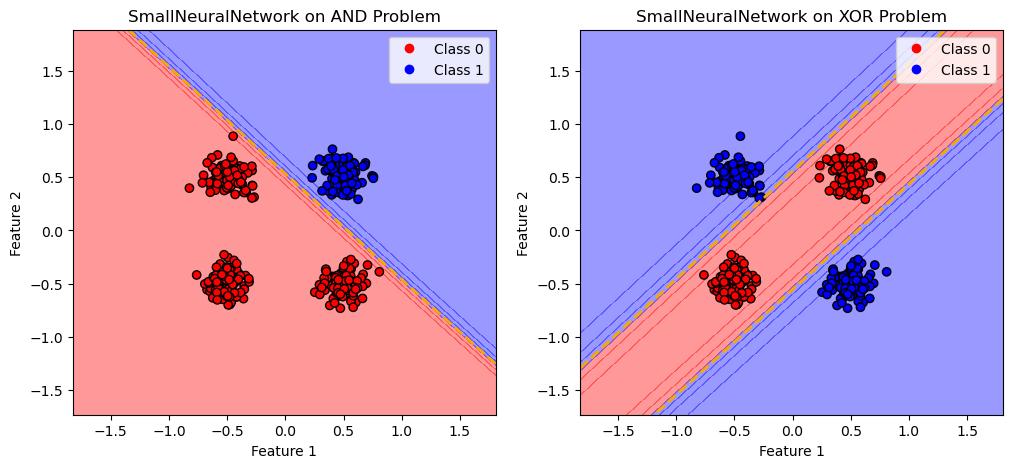

In [137]:
class SmallNeuralNetwork(nn.Module):
    def __init__(self):
        super(SmallNeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(2, 2)
        self.hidden = nn.Sigmoid()
        self.linear_2 = nn.Linear(2, 1)
        self.output = nn.Sigmoid()

    def forward(self, x): # x is the input layer
        x = self.linear_1(x)
        h = self.hidden(x)
        logits = self.linear_2(h)
        p = self.output(logits)
        return p

demo_datasets.run(SmallNeuralNetwork());

## Exercise 2: Visualizing the hidden variables

To solve the XOR classification problem using feature engineering, we manually transformed the two input features into five new ones by applying quadratic transformations to the original features. In contrast, when addressing the same problem with a small neural network—as in the example above—the network automatically learns during training how to map the two input features into two new features within its hidden layer. This learned mapping makes the problem linearly separable, enabling the logistic regression classifier (the output neuron) to effectively solve it.

Expand the `SmallNeuralNetwork` class with a new method called `get_hidden` that will return the hidden later activations of the neural network.

In [139]:
from demos import ANDXORToyDatasets
import torch
import torch.nn as nn

demo_datasets = ANDXORToyDatasets()

class SmallNeuralNetwork(nn.Module):
    def __init__(self):
        super(SmallNeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(2, 2)
        self.hidden = nn.Sigmoid()
        self.linear_2 = nn.Linear(2, 1)
        self.output = nn.Sigmoid()

    def forward(self, x):
        x = self.linear_1(x)
        h = self.hidden(x)
        logits = self.linear_2(h)
        p = self.output(logits)
        return p

    # START EXERCISE 2.1 #
    #chat GPT
      def get_hidden(self, x):
        with torch.no_grad():  # no gradients needed for inspection
            z = self.linear_1(x)
            h = self.hidden(z)
        return h
    # START EXERCISE 2.1 #

        
model_and, model_xor = demo_datasets.run(SmallNeuralNetwork())

IndentationError: unindent does not match any outer indentation level (<string>, line 24)

We can now use the method that you have implemented to visualize the learned feature transformations:

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 

with torch.no_grad():    
    hidden_activations = model_xor.get_hidden(torch.tensor(demo_datasets.X_xor, dtype=torch.float32))

print(hidden_activations.shape)
plt.scatter(hidden_activations[:, 0], hidden_activations[:, 1], c=demo_datasets.y_xor, cmap=ListedColormap(['red', 'blue']), s=100)
plt.colorbar(label='Class Label')
plt.title('Hidden Layer Activations')
plt.xlabel('Hidden Node 1 Activation')
plt.ylabel('Hidden Node 2 Activation')
plt.grid(True)
plt.show()

AttributeError: 'SmallNeuralNetwork' object has no attribute 'get_hidden'

<font color="red">
    
1. In the visualization of the hidden layer activations, how does the separability of the data in the hidden space compare to the original input space? What does this tell us about the role of the hidden layer?     
    
2. Explain how the hidden layer activations enable the neural network to solve the XOR problem, which is not linearly separable in the original input space.

3. Why is it beneficial to let the neural network learn feature transformations automatically, rather than manually engineering features as we did in the quadratic logistic regression model?
    
4. What might be the effect of changing the number of neurons in the hidden layer on the neural network's ability to solve the XOR problem? Try increasing or decreasing the number of hidden neurons and observe the impact.

</font>

## Exercise 3: Designing neural networks for more complex classification problems

In this exercise, your task is to design and train neural networks to classify data from the 'circles' and 'spirals' datasets. These datasets present more complex patterns than the XOR problem and require more sophisticated neural network architectures to achieve good performance.

In [ ]:
from demos import ToyDataset

circles_dataset = ToyDataset(
    dataset_type='circles',
    n_samples=500,
    noise=0.1,
    scatter_color_0='red',
    scatter_color_1='blue'
)

spirals_dataset = ToyDataset(
    dataset_type='spirals',
    n_samples=500,
    noise=1.5,
    scatter_color_0='red',
    scatter_color_1='blue'
)

circles_dataset.plot()
spirals_dataset.plot()


Implement neural network models suitable for the 'circles' and 'spirals' datasets. These datasets have complex patterns that are not linearly separable, making them ideal for testing different neural network architectures.

An **architecture** in the context of neural networks refers to the specific design and structure of the model. This includes the number of input neurons, the number of hidden layers, the number of neurons within each hidden layer, and the way these layers are connected. Different architectures can lead to varying model performances depending on the nature of the data and the task at hand.

To experiment with these architectures, you should try varying:
1. **The number of neurons**: Adjusting the number of neurons in each hidden layer affects the model's capacity to learn from the data. A smaller number of neurons may not be enough to capture the complexity of the patterns in the data, while too many neurons might lead to overfitting.
2. **The number of hidden layers**: This involves changing the depth of the network by adding or removing hidden layers. A deeper network can capture more complex relationships in the data but may require more data and computational power to train effectively.

You can use the `run` method from the `ToyDataset` class to train these models with different architectures. Here's an example of how the solution for the 'circles' dataset might look when using the small neural network model from the previous example:

In [ ]:
import torch
import torch.nn as nn

demo_datasets = ANDXORToyDatasets()

class SmallNeuralNetwork(nn.Module):
    def __init__(self):
        super(SmallNeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(2, 2)
        self.hidden = nn.Sigmoid()
        self.linear_2 = nn.Linear(2, 1)
        self.output = nn.Sigmoid()

    def forward(self, x):
        x = self.linear_1(x)
        h = self.hidden(x)
        logits = self.linear_2(h)
        p = self.output(logits)
        return p
            
circles_dataset.run(SmallNeuralNetwork())

And here is the solution for the spirals dataset:

In [ ]:
spirals_dataset.run(SmallNeuralNetwork())

In [ ]:
import torch
import torch.nn as nn

# your implementation goes here


<font color="red">
    
1. What challenges did you encounter when designing neural networks for these datasets compared to simpler datasets like XOR?

2. How did the complexity of the datasets influence your choice of network architecture and training parameters?

3. Discuss how the depth and width of your neural networks affected their ability to model the complex patterns in the data.

</font>

## Exercise 4: The role of the non-linearities in neural networks

As neural networks become deeper, the activation functions used in each layer can significantly impact the model's ability to learn effectively. The activation function is essential because it introduces non-linearity into the model, allowing the network to approximate complex functions and patterns in the data. However, not all activation functions perform equally well, especially as networks grow deeper.

One critical challenge in deep neural networks is the vanishing gradient problem. When using certain activation functions, such as the sigmoid, the gradients of the loss function with respect to the weights can become very small during backpropagation. This "vanishing gradient" slows down the weight updates and, in extreme cases, can stop the training process altogether, preventing the network from learning effectively.

### Understanding the Vanishing Gradient Problem

The vanishing gradient problem occurs because, during backpropagation, the gradient is computed as the product of many small derivatives. For activation functions like the sigmoid, these derivatives are often less than 1.0, and multiplying many small numbers together results in a value that approaches zero. When this happens, the gradients of the earlier layers (closer to the input) become very small, making it difficult for the network to learn meaningful representations in those layers.

To overcome this problem, alternative activation functions, such as ReLU (Rectified Linear Unit) and Tanh (Hyperbolic Tangent), have been introduced:

- ReLU: The ReLU activation function addresses the vanishing gradient problem by returning zero for any negative input and a linear value for positive inputs. This function maintains larger gradients during backpropagation, which allows for faster and more effective training of deep networks. However, ReLU can sometimes lead to "dead neurons" (neurons that output zero for all inputs) if too many neurons are set to zero.
- Tanh: The Tanh activation function is similar to the sigmoid but outputs values between -1 and 1, rather than 0 and 1. While it can still suffer from vanishing gradients, it usually performs better than the sigmoid function since its output is centered around zero, which helps mitigate some of the issues.

Please look at the graphs displaying these activation functions below. Try to imagine what the differences between the graphs are regarding the gradient / derivative around the zero point and how this relates to the vanishing gradient problem.

In [ ]:
import figures
figures.plot_sigmoid_relu_tanh()

Modify your neural network models from Exercise 3 to replace the sigmoid activation function with ReLU or Tanh in the hidden layers. You can experiment with different architectures and depths of the network to observe how these changes impact the training process.
Train your models again on the 'circles' and 'spirals' datasets using the new activation functions. Use the run method from the ToyDataset class to handle the training process.

In [ ]:
# your implementation goes here

<font color="red">
    
1. Why is the sigmoid activation function less suitable for deeper neural networks?

2. How did changing the activation function to ReLU or Tanh affect the training process and performance of your neural networks?

3. Based on your observations, which activation function would you recommend for deeper networks, and why?
   
5. Can ReLU or TanH be used as output nonlinearies? Motivate your answer.

6. What will happen if you remove all nonlinearities from the model, except the output nonlinearity?
    
</font>

# Project 2.3: Application of neural networks to a case study

NB: From this section (2.3) onwards, your answers will be checked and graded!

## Problem introduction

In this project, we will apply neural networks to a real-world case study involving breast ultrasound image classification. Specifically, we will work with the BreastMNIST dataset that is available from the [MedMNIST](https://github.com/MedMNIST/MedMNIST) package. The BreastMNIST dataset contains small grayscale image patches (28×28 pixels) extracted from breast ultrasound images. Each image is labeled as either benign (negative class) or malignant (positive class). Your goal is to build, evaluate and analyze a neural network model that can accurately classify these images.

## Dataset

The dataset is already split into training, validation, and test subsets, so we can use these splits for our experimental setup. The code below does all the necessary steps to download and prepare the BreastMNIST dataset for training and evaluation of PyTorch models. First, two transformations are applied to the "raw" dataset:
- ToTensor: Converts the NumPy array to a PyTorch tensor and rearranges the dimensions to match PyTorch's expected format (C×H×W).
- Normalize: Normalizes the tensor using the provided mean and standard deviation for each channel (RGB). Normalization centers the data around zero and scales it, which helps the neural network to learn more effectively.

Note that the same transformation is applied to all three subsets (training, validation and test). Then, three data loaders, one for each subsets, are created. The `DataLoader` class provides an efficient way to iterate over the dataset, which we need for the gradient descent optimization. It handles batching of data and shuffling, among other things. Setting shuffle=True for the training loader ensures that the data is shuffled each epoch, which helps in reducing overfitting.

In [ ]:
# run this if you have not installed MedMNIST
!pip install medmnist

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from medmnist import INFO, Evaluator
from medmnist import BreastMNIST

# select dataset
data_flag = 'breastmnist'
download = True

# get dataset info
info = INFO[data_flag]
task = info['task']
n_classes = len(info['label'])

# data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# initialize datasets
train_dataset = BreastMNIST(split='train', transform=transform, download=download)
val_dataset = BreastMNIST(split='val', transform=transform, download=download)
test_dataset = BreastMNIST(split='test', transform=transform, download=download)

# data loaders
batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
print(train_dataset)

### Visualizing sample images

We can visualize some of the images in the BreastMNIST dataset in the following way:

In [ ]:
num_samples = 25
num_rows = 5
num_cols = 5

indices = list(range(len(train_dataset)))
random.shuffle(indices)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
fig.suptitle('BreastMNIST samples', fontsize=16)

for i in range(num_samples):
    image, label = train_dataset[indices[i]]
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'Class: {int(label.item())}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

## Implementing a baseline neural network

The code below defines a "baseline" neural network that can be used to solve this problem. It consists of two hidden layers, the first one with 128 neurons and the second one with 64 neurons, and an output layer. The size of the input corresponds to the number of pixels in the input images and the output size is one since we have a binary classification problem. 

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()        
        self.linear2 = nn.Linear(128, 64)        
        self.relu2 = nn.ReLU()        
        self.output = nn.Linear(64, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # flatten the 2D input image to 1D
        x = x.view(x.size(0), -1)
        
        x = self.linear1(x)        
        x = self.relu1(x)        
        x = self.linear2(x)        
        x = self.relu2(x)        
        x = self.output(x)
        out = self.sigmoid(x)
        
        return out

# BreastMNIST images are 28x28 pixels
input_size = 28 * 28  

# binary label, we need one output neuron
output_size = 1

model = Net(input_size, output_size)

## Training the model

Here, we implement the training loop for a neural network model in PyTorch, designed to train the model and evaluate its performance. Let's break down the different components and their function:

1. **Criterion (`nn.BCELoss`)**: 
   - The `criterion` defines the loss function used to measure how far the model's predictions are from the true labels. In this case, we use `BCELoss` (Binary Cross Entropy Loss), which is suitable for binary classification problems where the output is a probability between 0 and 1.

2. **Optimizer (`optim.SGD`)**:
   - We use Stochastic Gradient Descent (SGD) with a learning rate of 0.005 and momentum of 0.95. Momentum helps accelerate the optimizer's updates, leading to faster convergence.

3. **Training Function (`train`)**:
   - This function trains the model for one **epoch**, meaning it goes through the entire dataset once, processing all batches.
   - `model.train()` puts the model in training mode.
   - We iterate over the `loader`, which provides batches of images and labels.
   - Before performing the backpropagation, `optimizer.zero_grad()` resets the gradients, and `loss.backward()` computes the gradients of the loss w.r.t. all parameters in the model.
   - The `optimizer.step()` updates the model's parameters.
   - `running_loss` tracks the average loss per batch during training.

4. **Evaluation Function (`evaluate`)**:
   - This function evaluates the model's performance on the validation set.
   - `model.eval()` switches the model to evaluation mode, ensuring that operations like dropout (if any) behave differently.
   - `torch.no_grad()` disables gradient calculations to save memory and computation.
   - The function calculates the loss and accuracy of the model’s predictions, converting the predicted outputs into binary values using a threshold of 0.5.
   - The accuracy is computed by comparing predictions with the true labels.

5. **Training Loop**:
   - The loop runs for a specified number of `epochs`, which is the number of times the model is trained on the entire dataset.
   - After each epoch, the model is trained on the training set and evaluated on the validation set. 
   - We keep track of both training and validation losses, along with validation accuracy.
   - If the validation loss improves, the model's state is saved to a file (`best_model.pth`), ensuring that we retain the best version of the model during training.


In [ ]:
criterion = nn.BCELoss() 
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.95)

# training function
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        # convert labels to float for BCELoss            
        labels = labels.float()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)        
        loss.backward()        
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(loader)

# evaluation function
def evaluate(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            # convert labels to float for BCELoss            
            labels = labels.float()        
        
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()            
            # apply threshold to get binary predictions
            predicted = (outputs > 0.5).float()  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    avg_loss = running_loss / len(loader)
    return avg_loss, accuracy

# training loop
num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy = evaluate(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%')
    
    # Check for the best validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'New best model saved at epoch {epoch+1} with validation loss {val_loss:.4f}')


Let's plot the training and validation loss curves:

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


## Evaluation on the test set

In [ ]:
# load the best model's weights
model.load_state_dict(torch.load('best_model.pth'))

# evaluate the best model on the test dataset
test_loss, test_accuracy = evaluate(model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

## Question 1: Neural network architecture

Review the baseline neural network implementation and ensure you’re familiar with all the details. Then, answer the following questions.

<font color="red">
    
1. If we change the first layer of the model from `self.linear1 = nn.Linear(input_size, 128)` to `self.linear1 = nn.Linear(input_size, 64)`, how wil we have to change the second linear layer?
   
2. For a binary classification problem (i.e. a problem with two classes) we have defined one output neuron. How many output neurons do we need for a classification problem with 3 classes? Can we still use sigmoid activation function in that case? Motivate your answer. 

</font>

## Question 2: Stochastic gradient descent

Train the baseline model using different batch sizes (e.g. 1, 4, 8, 16, 32, 64). Next, experiment with varying learning rates for the stochastic gradient descent optimizer (e.g. 1, 0.1, 0.01, 0.001, 0.0001). Analyze the resulting training and validation loss curves.

<font color="red">
    
1. Does the training of the baseline model show signs of overfitting?
   
2. How does changing the batch size impact the model's performance?
   
3. What effects does adjusting the learning rate have on the training process and the model's performance?
   
4. What are the advantages of using the stochastic gradient descent optimizer over the traditional gradient descent algorithm? Are there any potential drawbacks?
   
</font>

## Question 3: Batch normalization and dropout
Perform experiments by adding batch normalization and dropout layers and observe how they affect model performance, training stability, and generalization.

You can add batch normalization after each linear layer and dropout before each activation layer in your baseline model. For example:

~~~
self.batchnorm1 = nn.BatchNorm1d(128)
self.dropout = nn.Dropout(p=0.5)
~~~

And apply them in the forward pass:

~~~
x = self.linear1(x)
x = self.batchnorm1(x)
x = self.relu1(x)
x = self.dropout(x)
~~~


<font color="red">
    
1. How does adding batch normalization after the first and second linear layers affect the convergence speed of the model?
    
2. What changes do you observe in the validation accuracy when adding dropout with different probabilities (e.g., p=0.2, p=0.5) to the model?

3. Why does dropout behave differently during training and evaluation, and how can this impact the model's performance on unseen data?

4. Compare the training and validation loss curves for models with only dropout, only batch normalization, and both techniques combined. What differences do you observe?

5. How does batch normalization help with vanishing or exploding gradients, especially in deeper networks? Did you observe any such issues in your experiments?
</font>